# Init

## Imports

In [14]:
import sys, os

import tensorflow as tf

import numpy as np

import requests

import matplotlib

# Specify the backend of matplotlib to display graphs (here tkinter backend)
matplotlib.use("TkAgg")

from matplotlib import pyplot as plt

# Used to display matplotlib inside jupyter notebook
%matplotlib inline


# Disable tensorflow update warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Declare Global Consts

In [15]:
API_KEY  = 'XXXXXXXXXXXXXXXXX'
LOOKBACK = 24
PREDICT  = 100
STOCK = 'DAX'

# Create dataset

## Fetch data

In [16]:
def fetch_data(stock: str) -> list:
    """
    fetches stock data from alphavantage.co
    """
    r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&outputsize=full&apikey={API_KEY}&datatype=csv')
    return r.text.split('\r\n')

dataset = fetch_data(STOCK)
print(dataset)

['timestamp,open,high,low,close,volume', '2019-10-30,27.2600,27.3500,27.2600,27.3500,1400', '2019-10-29,27.1000,27.2600,27.1000,27.2600,1800', '2019-10-28,27.2600,27.4600,27.2600,27.3490,3400', '2019-10-25,27.1300,27.1300,27.1300,27.1300,300', '2019-10-24,27.1400,27.2000,27.1270,27.1300,800', '2019-10-23,27.1380,27.1380,27.1380,27.1380,300', '2019-10-22,27.0100,27.0300,26.8200,26.8200,900', '2019-10-21,27.0800,27.1560,27.0800,27.1100,3900', '2019-10-18,26.7500,26.8500,26.6550,26.8500,1400', '2019-10-17,26.8400,26.8960,26.8400,26.8960,500', '2019-10-16,26.5000,26.6000,26.4800,26.6000,1100', '2019-10-15,26.2000,26.5920,26.2000,26.4800,3000', '2019-10-14,26.2430,26.2430,26.2430,26.2430,800', '2019-10-11,26.0600,26.3110,26.0600,26.1000,4800', '2019-10-10,25.2600,25.4070,25.2600,25.4070,500', '2019-10-09,25.2080,25.2080,25.2080,25.2080,100', '2019-10-08,25.0700,25.0700,24.9200,24.9600,2300', '2019-10-07,25.1100,25.1100,25.1100,25.1100,700', '2019-10-04,25.0300,25.0300,24.9350,24.9350,1600',

In [17]:
def format_data(dataset: list) -> (list, list):
    """
    handles csv format and returns the label and the values as lists
    """
    tab = []
    for line in dataset:
        tab.append(line.split(','))
    for line in tab[1:]:
        for i in range(len(line)):
            if i == 0:
                line[i] = len(tab) - tab.index(line) - 1
            line[i] = float(line[i])    
    labels = tab[0]
    tab = list(reversed(tab[1:]))
    tab = tab[1:] # Remove last line which is empty
    return labels, tab    

labels, dataset = format_data(dataset)

## Visualize dataset

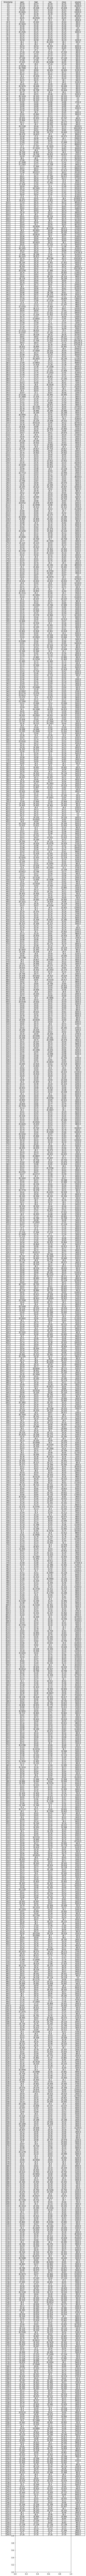

In [18]:
def visualize_data(labels: list, dataset: list) -> None:
    """
    plots a table to summarize the csv file
    """
    plt.table(cellText=dataset,
          colWidths = [0.25]*len(dataset[0]),
          colLabels=labels,
          cellLoc = 'center', rowLoc = 'center',
          loc='top')

visualize_data(labels, dataset)

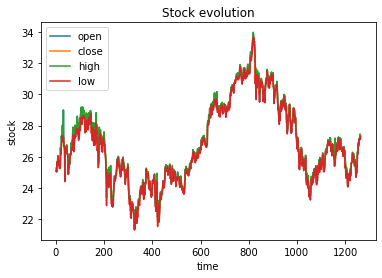

In [19]:
def plot_data(dataset: list) -> None:
    """
    displays the stock prices movements over the all dataset
    """
    data_open = [data[1] for data in dataset]
    data_high = [data[2] for data in dataset]
    data_low = [data[3] for data in dataset]
    data_close = [data[4] for data in dataset]
    data_time = [data[0] for data in dataset]
    plt.plot(data_time , data_open)
    plt.plot(data_time , data_close)
    plt.plot(data_time , data_high)
    plt.plot(data_time , data_low)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['open', 'close', 'high', 'low'], loc='upper left')
    plt.show()

plot_data(dataset)

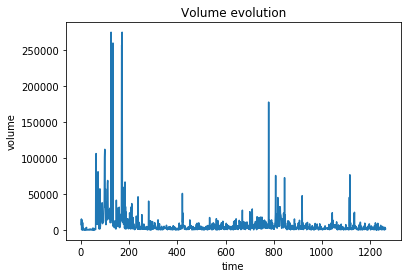

In [20]:
def plot_volumes(dataset: list) -> None:
    """
    plots the stock evolution over the all dataset
    """
    data_volume = np.array([data[5] for data in dataset])
    data_time = [data[0] for data in dataset]
    plt.plot(data_time , data_volume)
    plt.title('Volume evolution')
    plt.ylabel('volume')
    plt.xlabel('time')
    plt.show()

plot_volumes(dataset)

## Normalize data

In [21]:
def normalize_data(dataset: list) -> list:
    """
    normalisez all values in dataset array
    """
    dataset = np.swapaxes(dataset,0,1)[1:]
    for i in range(len(dataset)):
        dataset[i] = (dataset[i] - min(dataset[i])) / (max(dataset[i]) - min(dataset[i]))
    dataset = np.swapaxes(dataset, 0, 1)
    return dataset

dataset = normalize_data(dataset)
print(dataset)

[[0.29992107 0.30017796 0.30694669 0.30696279 0.02693848]
 [0.3038674  0.29376493 0.31098546 0.30209938 0.05533309]
 [0.29502762 0.28077854 0.30193861 0.28896814 0.0010921 ]
 ...
 [0.47119179 0.47573469 0.4822294  0.4771014  0.01237714]
 [0.45856354 0.45970211 0.46930533 0.46988733 0.0065526 ]
 [0.47119179 0.46691677 0.4822294  0.47718246 0.00509647]]


## Split dataset

In [22]:
def split_dataset(dataset: str) -> (list, list):
    """
    creates arrays of len LOOKBACK for each time unit before the current time unit in the first array
    the current time unit (output) is appended to the second array
    """
    x, y = [], []
    for i in range(LOOKBACK, len(dataset)):
        x.append(dataset[i-LOOKBACK:i])
        y.append(dataset[i])
    return np.array(x), np.array(y)

x_train, y_train = split_dataset(dataset)

x_test = x_train[int(len(x_train) - PREDICT):]
x_train = x_train[:int(len(x_train) - PREDICT)]

y_test = y_train[int(len(y_train) - PREDICT):]
y_train = y_train[:int(len(y_train) - PREDICT)]

print("Train\t", x_train.shape, '\t', y_train.shape)
print("Test\t", x_test.shape, '\t', y_test.shape)

Train	 (1140, 24, 5) 	 (1140, 5)
Test	 (100, 24, 5) 	 (100, 5)


# AI

## Define model

In [32]:
def define_model():
    """
    define model type and layers
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(len(x_train), input_shape=(LOOKBACK, 5), return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(5, activation='relu'))
    return model

model = define_model()

## Compile model

In [33]:
def compile_model(model: object) -> object:
    """
    defines model compilation
    """
    model.compile(optimizer='adam',loss='mse')
    model.summary()
    return model

model = compile_model(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1140)              5225760   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1140)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5705      
Total params: 5,231,465
Trainable params: 5,231,465
Non-trainable params: 0
_________________________________________________________________


## Train AI

In [34]:
def train_ai(model: object, x_train: list, y_train: list):
    """
    runs training on dataset
    """
    history = model.fit(x_train, y_train, epochs=20, batch_size=27, validation_split=0.2)
    return history, model
    
history, model = train_ai(model, x_train, y_train)

Train on 912 samples, validate on 228 samples
Epoch 1/20
912/912 [==============================] - 32s 35ms/sample - loss: 0.0145 - val_loss: 0.0011
Epoch 2/20
912/912 [==============================] - 36s 39ms/sample - loss: 0.0032 - val_loss: 0.0012
Epoch 3/20
912/912 [==============================] - 21s 23ms/sample - loss: 0.0032 - val_loss: 0.0010
Epoch 4/20
912/912 [==============================] - 21s 23ms/sample - loss: 0.0030 - val_loss: 0.0014
Epoch 5/20
912/912 [==============================] - 23s 25ms/sample - loss: 0.0035 - val_loss: 0.0012
Epoch 6/20
912/912 [==============================] - 27s 29ms/sample - loss: 0.0029 - val_loss: 9.5125e-04
Epoch 7/20
912/912 [==============================] - 25s 27ms/sample - loss: 0.0029 - val_loss: 9.8302e-04
Epoch 8/20
912/912 [==============================] - 23s 25ms/sample - loss: 0.0029 - val_loss: 8.4596e-04
Epoch 9/20
912/912 [==============================] - 23s 26ms/sample - loss: 0.0026 - val_loss: 0.0013
Epoch 

## Visualize training

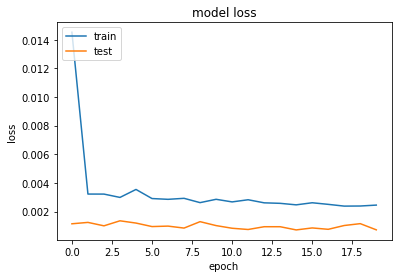

In [35]:
def plot_loss(history: object) -> None:
    """
    plots loss variation over all the training and testing datasets
    """
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_loss(history)

## Test model

In [36]:
def test_model(model: object, x_test: list, y_test: list) -> int:
    """
    returns the average error percentage on predictions
    """
    output = model.predict(np.array([x_test]))
    error = []
    for i in range(len(output)):
        error.append(abs(100 - output[i] * 100 / y_test[i]))
    error = np.array(error)
    return np.mean(error)

errors_means = []
for i in range(PREDICT):
    errors_means.append(test_model(model, x_test[i], y_test[i]))
print("\nAVERAGE ERROR", np.mean(np.array(errors_means)), "% (calculated on the", PREDICT, "last time units of the dataset)")


AVERAGE ERROR 23.781511 % (calculated on the 100 last time units of the dataset)


## Visualize accuracy

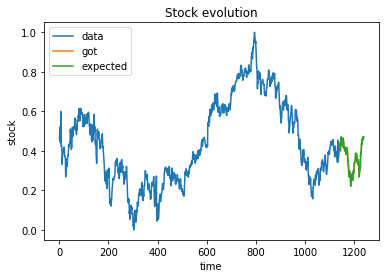

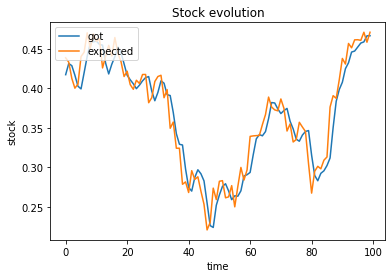

In [37]:
def plot_result(y_train: list, x_test: list, y_test: list) -> None:
    """
    plots all prediction compared to expected outputs
    """
    # Dataset
    data_open = [data[1] for data in y_train]
    data_high = [data[2] for data in y_train]
    data_low = [data[3] for data in y_train]
    data_close = [data[4] for data in y_train]
    data_time = [i for i in range(len(y_train))]
    plt.plot(data_time , data_open)
    
    # Prediction
    data_time = [data_time[-1] + i for i in range(len(y_test))]
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)

    # Expected
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = y_test[i]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['data', 'got', "expected"], loc='upper left')
    plt.show()
    
     # Prediction
    data_time = [i for i in range(len(y_test))]
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)

    # Expected
    data_open, data_high, data_low, data_close = [], [], [], []
    for i in range(PREDICT):
        tab = y_test[i]
        data_open.append(tab[0])
        data_high.append(tab[1])
        data_low.append(tab[2])
        data_close.append(tab[3])
    plt.plot(data_time , data_open)
    plt.title('Stock evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['got', "expected"], loc='upper left')
    plt.show()

plot_result(y_train, x_test, y_test)

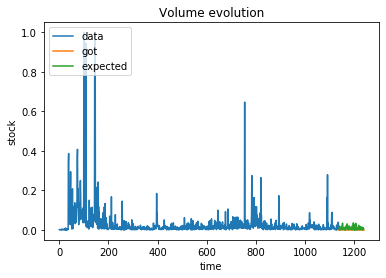

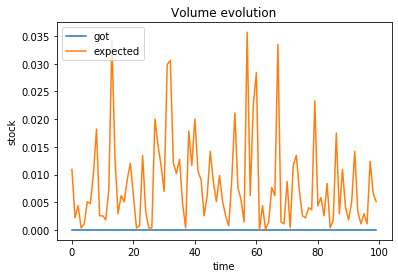

In [38]:
def plot_volumes_result(y_train: list, x_test: list, y_test: list) -> None:
    """
    plots volumes predictions compared to actual values
    """
    # Dataset
    data_volume = [data[4] for data in y_train]
    data_time = [i for i in range(len(y_train))]
    plt.plot(data_time , data_volume)
    
    # Prediction
    data_time = [data_time[-1] + i for i in range(len(y_test))]
    data_volume = []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)

    # Expected
    data_volume = []
    for i in range(PREDICT):
        tab = y_test[i]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)
    plt.title('Volume evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['data', 'got', "expected"], loc='upper left')
    plt.show()
    
    # Prediction
    data_time = [i for i in range(len(y_test))]
    data_volume = []
    for i in range(PREDICT):
        tab = model.predict(np.array([x_test[i]]))[0]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)

    # Expected
    data_volume = []
    for i in range(PREDICT):
        tab = y_test[i]
        data_volume.append(tab[4])
    plt.plot(data_time , data_volume)
    plt.title('Volume evolution')
    plt.ylabel('stock')
    plt.xlabel('time')
    plt.legend(['got', "expected"], loc='upper left')
    plt.show()

plot_volumes_result(y_train, x_test, y_test)